In [1]:
using ModelingToolkit, Plots, DifferentialEquations

In [2]:
@variables t
@connector function Pin(;name)
    sts = @variables v(t)=1.0 i(t)=1.0 [connect = Flow]
    ODESystem(Equation[], t, sts, []; name=name)
end

function Ground(;name)
    @named g = Pin()
    eqs = [g.v ~ 0]
    compose(ODESystem(eqs, t, [], []; name=name), g)
end

function OnePort(;name)
    @named p = Pin()
    @named n = Pin()
    sts = @variables v(t)=1.0 i(t)=1.0
    eqs = [
           v ~ p.v - n.v
           0 ~ p.i + n.i
           i ~ p.i
          ]
    compose(ODESystem(eqs, t, sts, []; name=name), p, n)
end

function Resistor(;name, R = 1.0)
    @named oneport = OnePort()
    @unpack v, i = oneport
    ps = @parameters R=R
    eqs = [
           v ~ i * R
          ]
    extend(ODESystem(eqs, t, [], ps; name=name), oneport)
end

function Capacitor(;name, C = 1.0)
    @named oneport = OnePort()
    @unpack v, i = oneport
    ps = @parameters C=C
    D = Differential(t)
    eqs = [
           D(v) ~ i / C
          ]
    extend(ODESystem(eqs, t, [], ps; name=name), oneport)
end

function ConstantVoltage(;name, V = 1.0)
    @named oneport = OnePort()
    @unpack v = oneport
    ps = @parameters V=V
    eqs = [
           V ~ v
          ]
    extend(ODESystem(eqs, t, [], ps; name=name), oneport)
end

ConstantVoltage (generic function with 1 method)

In [3]:
R = 1.0
C = 1.0
V = 1.0
@named resistor = Resistor(R=R)
@named capacitor = Capacitor(C=C)
@named source = ConstantVoltage(V=V)
@named ground = Ground()

rc_eqs = [
          connect(source.p, resistor.p)
          connect(resistor.n, capacitor.p)
          connect(capacitor.n, source.n)
          connect(capacitor.n, ground.g)
         ]

@named _rc_model = ODESystem(rc_eqs, t)
@named rc_model = compose(_rc_model,
                          [resistor, capacitor, source, ground])

Model rc_model with 17 equations
States (20):
  resistor₊v(t) [defaults to 1.0]
  resistor₊i(t) [defaults to 1.0]
  resistor₊p₊v(t) [defaults to 1.0]
  resistor₊p₊i(t) [defaults to 1.0]
  resistor₊n₊v(t) [defaults to 1.0]
  resistor₊n₊i(t) [defaults to 1.0]
⋮
Parameters (3):
  resistor₊R [defaults to 1.0]
  capacitor₊C [defaults to 1.0]
  source₊V [defaults to 1.0]

In [4]:
sys = structural_simplify(rc_model)

Model rc_model with 1 equations
States (1):
  capacitor₊v(t) [defaults to 1.0]
Parameters (3):
  resistor₊R [defaults to 1.0]
  capacitor₊C [defaults to 1.0]
  source₊V [defaults to 1.0]
Incidence matrix:sparse([1, 1], [1, 2], Num[×, ×], 1, 2)

In [5]:
u0 = [
      capacitor.v => 0.0
     ]

1-element Vector{Pair{Num, Float64}}:
 capacitor₊v(t) => 0.0

In [6]:
prob = ODAEProblem(sys, u0, (0, 10.0))

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 1-element Vector{Float64}:
 0.0

In [7]:
sol = solve(prob, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 19-element Vector{Float64}:
  0.0
  9.999999999999999e-5
  0.0010999999999999998
  0.011099999999999997
  0.076742091466188
  0.2256219976613778
  0.4455760022489606
  0.7272505097568545
  1.0899643857570624
  1.5331652827982714
  2.06972399829104
  2.705750446504391
  3.4562444530999095
  4.3378403240538095
  5.377903566781988
  6.614654307931712
  8.1073506878944
  9.946895379599903
 10.0
u: 19-element Vector{Vector{Float64}}:
 [0.0]
 [9.999500016666247e-5]
 [0.001099395221772342]
 [0.011038622307372232]
 [0.0738713206981718]
 [0.20198030129465663]
 [0.3595447255651815]
 [0.5167641452122546]
 [0.6637713825376194]
 [0.7841482271226826]
 [0.873778404447212]
 [0.9331779821204202]
 [0.9684489616227437]
 [0.9869310637824636]
 [0.9953772824474669]
 [0.9986536797747498]
 [0.9996930416967437]
 [0.9999471971800106]
 [0.9999499280997356]

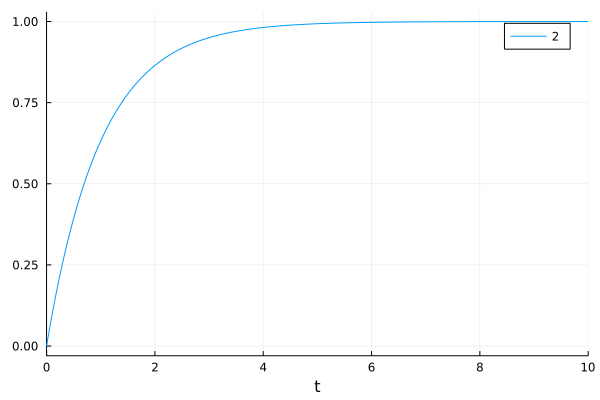

In [8]:
plot(sol)